In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as scopt
from scipy.spatial import KDTree

### Gradient descent variations

In [2]:
def pairwise_func(x, y):
    if np.linalg.norm(x - y) > 1:
        return 0
    return (1 - (x - y) @ (x - y)) ** 2

In [3]:
def pairwise_dists(X):
    squared_norms = np.sum(X**2, axis=1)
    pairwise_sq_dist = squared_norms[:, np.newaxis] + squared_norms - 2 * X @ X.T
    return np.sqrt(pairwise_sq_dist)

In [4]:
def func_old(X):
    # TODO make it numpyic
    ans = 0
    for i in range(len(X)):
        for j in range(i + 1, len(X)):
            ans += pairwise_func(X[i], X[j])
    return ans

In [5]:
def func(X):
    squared_norms = np.sum(X**2, axis=1)
    squared_dists = squared_norms[:, np.newaxis] + squared_norms - 2 * X @ X.T
    squared_dists = np.minimum(squared_dists, 1)
    potentials = (1 - squared_dists)**2
    return (np.sum(potentials) - X.shape[0]) / 2

In [6]:
def pairwise_grad(x, y):
    # gradient with respect to x
    if np.linalg.norm(x - y) > 1:
        return np.zeros_like(x)
    return - 4 * (1 - (x - y) @ (x - y)) * (x - y)

In [7]:
def grad_old(X):
    # TODO numpyify
    ans = []
    for i in range(len(X)):
        next_grad = 0
        for j in range(len(X)):
            if i != j:
                next_grad = next_grad + pairwise_grad(X[i], X[j])
        ans.append(next_grad.copy())

    return np.array(ans)

In [8]:
def grad(X):
    squared_norms = np.sum(X**2, axis=1)
    squared_dists = squared_norms[:, np.newaxis] + squared_norms - 2 * X @ X.T
    squared_dists = np.minimum(squared_dists, 1)
    multipliers = 4 * (squared_dists - 1)
    
    differences = X[:, np.newaxis, :] - X[np.newaxis, :, :]
    grads = differences * multipliers[:, :, np.newaxis]
    return np.sum(grads, axis=1)

In [9]:
def grad_kdtree(X, inds):
    differences = X[:, np.newaxis, :] - X[inds[:, 1:]]
    
    dists = np.minimum(np.linalg.norm(differences, axis=2), 1)
    multipliers = 4 * (dists**2 - 1)
    
    grads = differences * multipliers[:, :, np.newaxis]
    return np.sum(grads, axis=1)

In [10]:
def renorm(X):
    # makes X[i] unit norm
    row_norms = np.linalg.norm(X, axis=1, keepdims=True)
    return X / row_norms

In [11]:
def gd(grad, x0, num_iter, tol, alpha):
    x = x0.copy()
    conv = [x.copy()]
    for iter_idx in range(num_iter):
        g = grad(x)
        next_x = renorm(x - alpha * g)
        if np.linalg.norm((next_x - x) / alpha) < tol:
            break
        x = next_x
        conv.append(x.copy())
    return x, conv

In [12]:
def heavy_ball(grad, x0, num_iter, tol, alpha, beta):
    x = x0.copy()
    conv = [x.copy()]
    for iter_idx in range(num_iter):
        g = grad(x)
        if np.linalg.norm(g) < tol:
            break
        if len(conv) > 1:
            next_x = renorm(x - alpha * g + beta * (x - conv[-2]))
        else:
            next_x = renorm(x - alpha * g)

        if np.linalg.norm((next_x - x) / alpha) < tol:
            break
        x = next_x
        conv.append(x.copy())
    return x, conv

In [13]:
def accelerated_gradient(func, gradient, x0, num_iter, tol, alpha, restart=False, adapt_step=False, alpha_min=1e-3):
    x = x0.copy()
    y = x0.copy()
    conv = [x.copy()]
    k = 0
    for iter_idx in range(num_iter):
        x_next = y - alpha * gradient(y)
        grad_x = gradient(x)
        if restart and func(x) < func(renorm(x_next)):
            if adapt_step and alpha > alpha_min:
                if func(x) < func(renorm(x - alpha * grad_x)):
                    alpha = alpha * 0.8
            x_next = x - alpha * grad_x
            k = 0
        y = x_next + (k + 1) / (k + 4) * (x_next - x)
        y = renorm(y)
        x_next = renorm(x_next)
        if np.linalg.norm((x - x_next) / alpha) < tol:
            break
        x = x_next.copy()
        g = gradient(x)
        conv.append(x.copy())
        k += 1
    return x, conv

In [14]:
def accelerated_gradient_kdt(func, x0, recomp_tree, num_neighbors, num_iter, tol, alpha, restart=False, adapt_step=False, alpha_min=1e-3):
    x = x0.copy()
    y = x0.copy()
    conv = [x.copy()]
    k = 0

    tree = KDTree(x)
    dists, inds = tree.query(x, k=num_neighbors)
    
    for iter_idx in range(num_iter):
        if iter_idx % recomp_tree == 0:
            tree = KDTree(x)
            dists, inds = tree.query(x, k=num_neighbors)
        
        x_next = y - alpha * grad_kdtree(y, inds)
        grad_x = grad_kdtree(x, inds)
        if restart and func(x) < func(renorm(x_next)):
            if adapt_step and alpha > alpha_min:
                if func(x) < func(renorm(x - alpha * grad_x)):
                    alpha = alpha * 0.8
            x_next = x - alpha * grad_x
            k = 0
        y = x_next + (k + 1) / (k + 4) * (x_next - x)
        y = renorm(y)
        x_next = renorm(x_next)
        if np.linalg.norm((x - x_next) / alpha) < tol:
            break
        x = x_next.copy()
        g = grad_kdtree(x, inds)
        conv.append(x.copy())
        k += 1
    return x, conv

In [15]:
def grad_projection_norm(X):
    g = grad(X)
    return np.linalg.norm(renorm(X + g) - X)

In [16]:
n = 4
N = 22
X0 = renorm(np.random.randn(N,n))

In [17]:
alpha = 0.003
beta = 0.9
num_iter = 500
tol = 1e-6

In [18]:
%%time
x_gd, conv_gd = gd(grad, X0, num_iter, tol, alpha)

CPU times: user 39.4 ms, sys: 980 μs, total: 40.4 ms
Wall time: 39.8 ms


In [19]:
%%time
x_hb, conv_hb = heavy_ball(grad, X0, num_iter, tol, alpha, beta)

CPU times: user 41.6 ms, sys: 1.94 ms, total: 43.6 ms
Wall time: 43 ms


In [20]:
%%time
x_ag, conv_ag = accelerated_gradient(func, grad, X0, num_iter, tol, alpha)

CPU times: user 96.8 ms, sys: 70 μs, total: 96.9 ms
Wall time: 96.4 ms


In [21]:
%time x_agkd, conv_agkd = accelerated_gradient_kdt(func, X0, 10, 20, num_iter, tol, alpha, restart=True, adapt_step=True, alpha_min=1e-3)

CPU times: user 130 ms, sys: 992 μs, total: 131 ms
Wall time: 131 ms


In [22]:
%%time
x_agr, conv_agr = accelerated_gradient(func, grad, X0, num_iter, tol, alpha, restart=True)

CPU times: user 100 ms, sys: 40 μs, total: 100 ms
Wall time: 99.9 ms


In [23]:
%%time
x_agra, conv_agra = accelerated_gradient(func, grad, X0, num_iter, tol, alpha, restart=True, adapt_step=True)

CPU times: user 95.3 ms, sys: 48 μs, total: 95.3 ms
Wall time: 94.8 ms


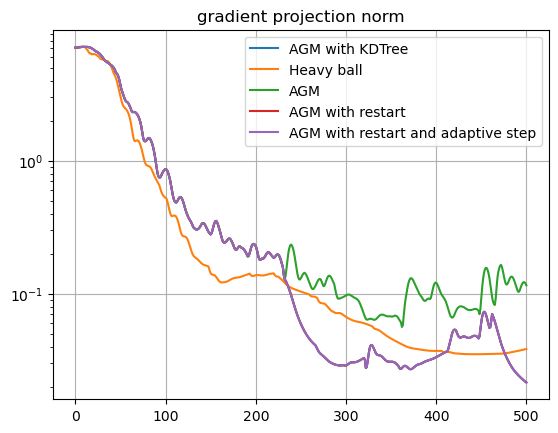

In [24]:
plt.semilogy([grad_projection_norm(x) for x in conv_agkd], label="AGM with KDTree")
plt.semilogy([grad_projection_norm(x) for x in conv_hb], label="Heavy ball")
plt.semilogy([grad_projection_norm(x) for x in conv_ag], label="AGM")
plt.semilogy([grad_projection_norm(x) for x in conv_agr], label="AGM with restart")
plt.semilogy([grad_projection_norm(x) for x in conv_agra], label="AGM with restart and adaptive step")
plt.title("gradient projection norm")
plt.legend()
plt.grid(True)

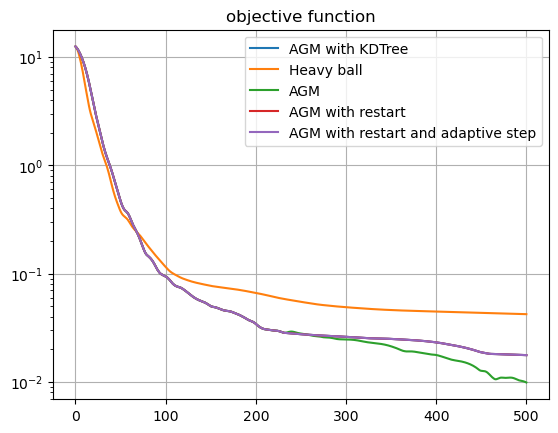

In [25]:
plt.semilogy([func(x) for x in conv_agkd], label="AGM with KDTree")
plt.semilogy([func(x) for x in conv_hb], label="Heavy ball")
plt.semilogy([func(x) for x in conv_ag], label="AGM")
plt.semilogy([func(x) for x in conv_agr], label="AGM with restart")
plt.semilogy([func(x) for x in conv_agra], label="AGM with restart and adaptive step")
plt.title("objective function")
plt.legend()
plt.grid(True)

### Moving each point into the center of the circumscribed sphere of the n+1 closest neighbors

In [26]:
n = 2
N = 5
X0 = renorm(np.random.randn(N,n))
X0

array([[ 0.19160854,  0.98147143],
       [-0.05184853, -0.99865496],
       [ 0.98751644,  0.15751595],
       [-0.45622874, -0.88986254],
       [ 0.90598751, -0.42330442]])

In [27]:
tree = KDTree(X0)
dists, inds = tree.query(X0, k=4)
dists, inds

(array([[0.        , 1.14558807, 1.5759862 , 1.98029896],
        [0.        , 0.41875905, 1.11735318, 1.55467384],
        [0.        , 0.58651451, 1.14558807, 1.55467384],
        [0.        , 0.41875905, 1.43989916, 1.78364847],
        [0.        , 0.58651451, 1.11735318, 1.43989916]]),
 array([[0, 2, 4, 3],
        [1, 3, 4, 2],
        [2, 4, 0, 1],
        [3, 1, 4, 2],
        [4, 2, 1, 3]]))

In [28]:
directions = X0[inds[:, 1:]] - X0[:, np.newaxis, :]
directions, np.linalg.norm(directions, axis=2)

(array([[[ 0.79590791, -0.82395548],
         [ 0.71437898, -1.40477585],
         [-0.64783728, -1.87133397]],
 
        [[-0.40438021,  0.10879242],
         [ 0.95783604,  0.57535054],
         [ 1.03936498,  1.15617091]],
 
        [[-0.08152893, -0.58082037],
         [-0.79590791,  0.82395548],
         [-1.03936498, -1.15617091]],
 
        [[ 0.40438021, -0.10879242],
         [ 1.36221625,  0.46655812],
         [ 1.44374518,  1.04737849]],
 
        [[ 0.08152893,  0.58082037],
         [-0.95783604, -0.57535054],
         [-1.36221625, -0.46655812]]]),
 array([[1.14558807, 1.5759862 , 1.98029896],
        [0.41875905, 1.11735318, 1.55467384],
        [0.58651451, 1.14558807, 1.55467384],
        [0.41875905, 1.43989916, 1.78364847],
        [0.58651451, 1.11735318, 1.43989916]]))

(-1.1, 1.1)

<Figure size 700x700 with 0 Axes>

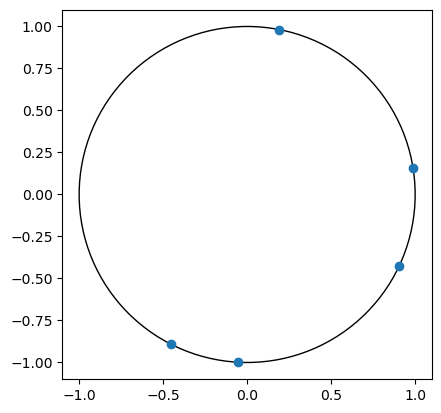

In [29]:
plt.figure(figsize=(7,7))
fig, ax = plt.subplots()
ax.set_aspect(1)
circle = plt.Circle((0, 0), 1, fill=False)
ax.add_patch(circle)
plt.scatter(X0[:,0], X0[:,1])
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

In [30]:
def optimize_by_centering(X0, max_iter, tol):
    # not stable
    
    x = X0.copy()

    for _ in range(max_iter):
        tree = KDTree(x)
        dists, inds = tree.query(x, k=x.shape[1] + 1)
        
        x_next = x.copy()
        for i in range(len(x)):
            if dists[i,1] < 1:
                x_next[i] = np.linalg.solve(x[inds[i,1:]], np.ones(x.shape[1]))
                # if x[i] was not inside the cone spanned by its neighbors, then move it in the opposite direction
                if np.any(np.linalg.solve(x[inds[i,1:]].T, x[i]) < 0):
                    x_next[i] = x[i] + 0.1 * (x[i] - x_next[i])

        x_next = renorm(x_next)
        if np.linalg.norm(x - x_next) < tol:
            break
        x = x_next

    return x

In [31]:
x = optimize_by_centering(X0, 100, 1e-6)

(-1.1, 1.1)

<Figure size 700x700 with 0 Axes>

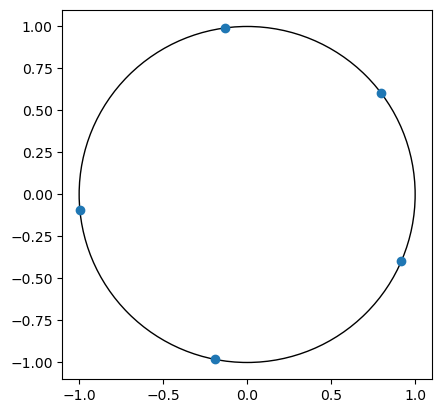

In [32]:
plt.figure(figsize=(7,7))
fig, ax = plt.subplots()
ax.set_aspect(1)
circle = plt.Circle((0, 0), 1, fill=False)
ax.add_patch(circle)
plt.scatter(x[:,0], x[:,1])
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

In [33]:
n = 6
N = 70
X0 = renorm(np.random.randn(N,n))

%%time
x = optimize_by_centering(X0, 500, 1e-6)
func(x)

### Sampling minimums of the potential

In [34]:
def grad_potentials(X, points):
    # returns the gradient of the potential in points
    sqnorms_X = np.sum(X**2, axis=1)
    sqnorms_points = np.sum(points**2, axis=1)
    squared_dists = sqnorms_X[:, np.newaxis] + sqnorms_points[np.newaxis, :] - 2 * X @ points.T
    squared_dists = np.minimum(squared_dists, 1)
    
    multipliers = 4 * (squared_dists - 1).T

    differences = X[np.newaxis, :, :] - points[:, np.newaxis, :]
    grads = - differences * multipliers[:, :, np.newaxis]
    return np.sum(grads, axis=1)

In [35]:
def potentials_in_points(X, points):
    # returns a vector of potentials for each point in points
    sqnorms_X = np.sum(X**2, axis=1)
    sqnorms_points = np.sum(points**2, axis=1)
    squared_dists = sqnorms_X[:, np.newaxis] + sqnorms_points[np.newaxis, :] - 2 * X @ points.T
    squared_dists = np.minimum(squared_dists, 1)
    potentials = (1 - squared_dists)**2
    return np.sum(potentials, axis=0)

In [54]:
def grad_projection_norm_points(X, points, alpha=1e-3):
    g = grad_potentials(X, points)
    return np.linalg.norm(renorm(points + alpha * g) - points) / alpha

In [37]:
n = 4
N = 24
num_points = 3

X0 = renorm(np.random.randn(N, n))
X, _ = accelerated_gradient_kdt(func, X0, 10, 20, 500, 1e-6, 0.01, True)
points = renorm(np.random.randn(num_points, n))

In [83]:
alpha = 0.03
beta = 0.9
num_iter = 500
tol = 1e-6

In [84]:
%%time
x_ag, conv_ag = accelerated_gradient(lambda p: np.sum(potentials_in_points(X, p)), lambda p: grad_potentials(X, p), 
                                     points, num_iter, tol, alpha)
x_agr, conv_agr = accelerated_gradient(lambda p: np.sum(potentials_in_points(X, p)), lambda p: grad_potentials(X, p), 
                                       points, num_iter, tol, alpha, restart=True)

CPU times: user 67.9 ms, sys: 1.99 ms, total: 69.9 ms
Wall time: 67.2 ms


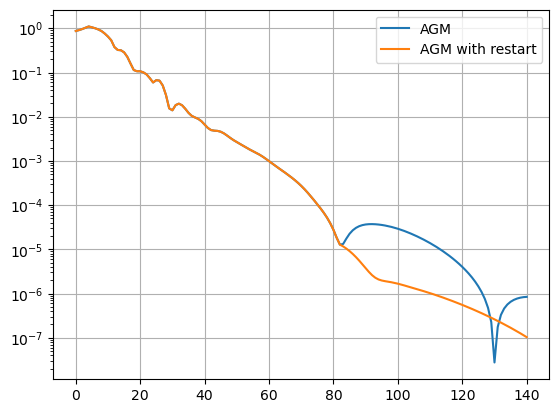

In [85]:
plt.semilogy([grad_projection_norm_points(X, x) for x in conv_ag], label="AGM")
plt.semilogy([grad_projection_norm_points(X, x) for x in conv_agr], label="AGM with restart")
plt.legend()
plt.grid(True)

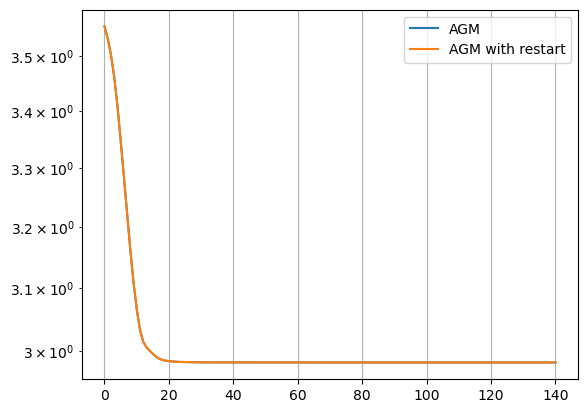

In [86]:
plt.semilogy([np.sum(potentials_in_points(X, p)) for p in conv_ag], label="AGM")
plt.semilogy([np.sum(potentials_in_points(X, p)) for p in conv_agr], label="AGM with restart")
plt.legend()
plt.grid(True)